# Data Preprocessing and Exploration

-This notebook initiates the model selection process by exploring the data and preprocessing it for model training and furthur processing.The data used is 2 years sales data of an online retailer in the UK between December 2009 and January 2012.

In [1]:
#Import the neccesary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
#Import data
#Workbook has two sheets
df1 = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2009-2010")
df2 = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011")
df1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
# Concatenate the DataFrames
merged_df = pd.concat([df1, df2], ignore_index=True)
merged_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
#Check the min date and max date of new dataframe
print("Merged max :", merged_df["InvoiceDate"].max())
print("Merged min :", merged_df["InvoiceDate"].min())

Merged max : 2011-12-09 12:50:00
Merged min : 2009-12-01 07:45:00


In [10]:
#Removed cancelled transactions
merged_df = merged_df[merged_df["Quantity"]>0]

In [11]:
#save the new dataframe to csv
merged_df.to_csv("uk_dataset_full.csv")

In [12]:
#Create date column to allow finding of daily sales volume
merged_df["InvoiceDate"] = pd.to_datetime(merged_df["InvoiceDate"])
merged_df["date"] = merged_df["InvoiceDate"].dt.date

In [13]:
#Group daily sales volume
merged_daily = merged_df.groupby('date')['Quantity'].sum().reset_index()
merged_daily.head()

,date,Quantity
0,2009-12-01,26434
1,2009-12-02,31938
2,2009-12-03,50898
3,2009-12-04,21405
4,2009-12-05,5119


In [14]:
#save the  daily sales volume
merged_daily.to_csv("uk_daily_sales_full.csv")

### Exploration and Cleaning

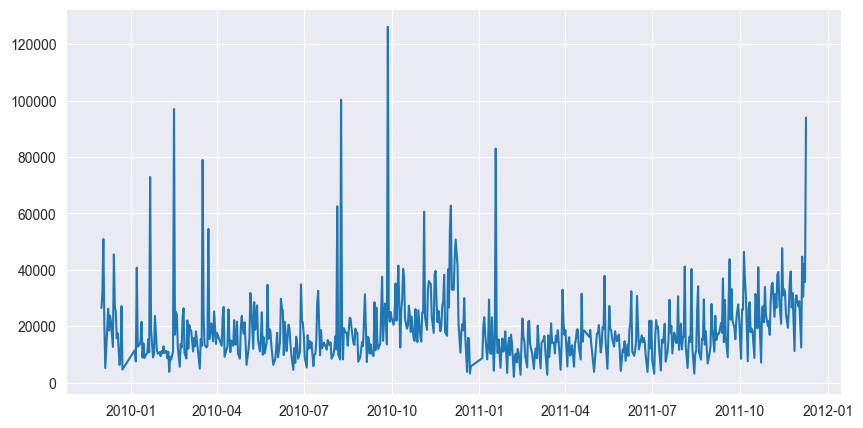

In [15]:
#Check the distribution
plt.figure(figsize=(10,5))
plt.plot(merged_daily["date"],merged_daily["Quantity"]);

In [16]:
#Overview of data
merged_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      604 non-null    object
 1   Quantity  604 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.6+ KB


In [18]:
#Convert date column to datetime
merged_daily["date"] = pd.to_datetime(merged_daily["date"])

In [17]:
#Descriptive statistics
merged_daily.describe()

#possibility of missing dates and outliers

,Quantity
count,604.000000
mean,19325.447020
std,12668.271498
min,2048.000000
25%,11863.000000
50%,16260.500000
75%,23450.250000
max,126182.000000


In [20]:
#Rename quantity column to lowercase
merged_daily.rename(columns={"Quantity":"quantity"},inplace=True)

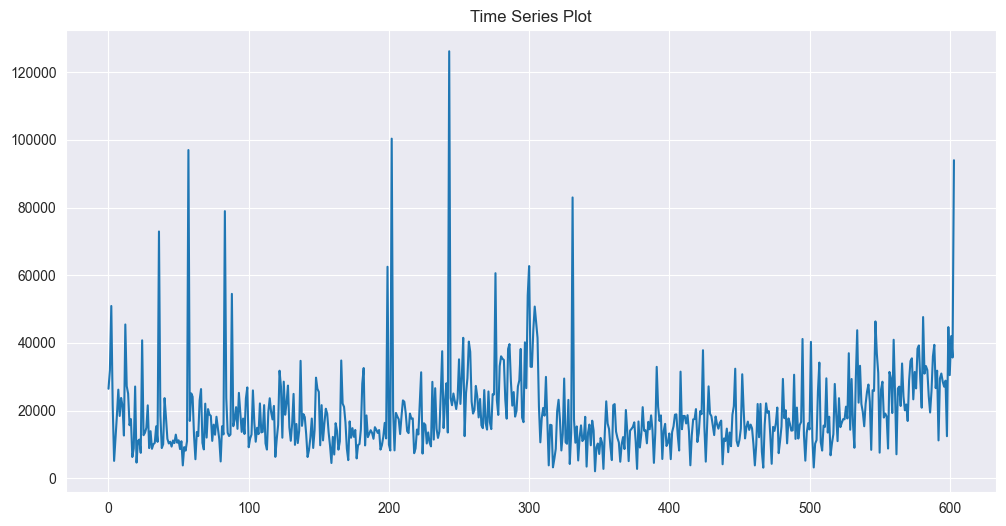

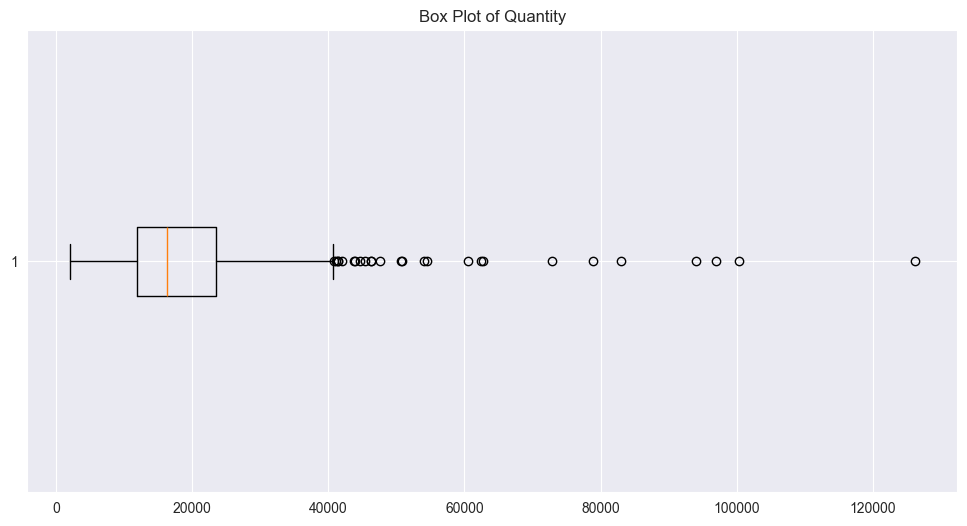

In [21]:
# Plot to visualise outliers
plt.figure(figsize=(12, 6))
plt.plot(merged_daily['quantity'])
plt.title('Time Series Plot')
plt.show()

# Box plot
plt.figure(figsize=(12, 6))
plt.boxplot(merged_daily['quantity'], vert=False)
plt.title('Box Plot of Quantity')
plt.show();

In [22]:
#Make a copy of the dataframe  
df = merged_daily.copy()


In [23]:
# Set winsorization threshold to convert any number above 60000 to 60000
threshold = 60000

# Winsorize the 'quantity' column
df['quantity_winsorized'] = df['quantity'].where(df['quantity'] <= threshold, threshold)
df.head(5)

,date,quantity,quantity_winsorized
0,2009-12-01,26434,26434
1,2009-12-02,31938,31938
2,2009-12-03,50898,50898
3,2009-12-04,21405,21405
4,2009-12-05,5119,5119


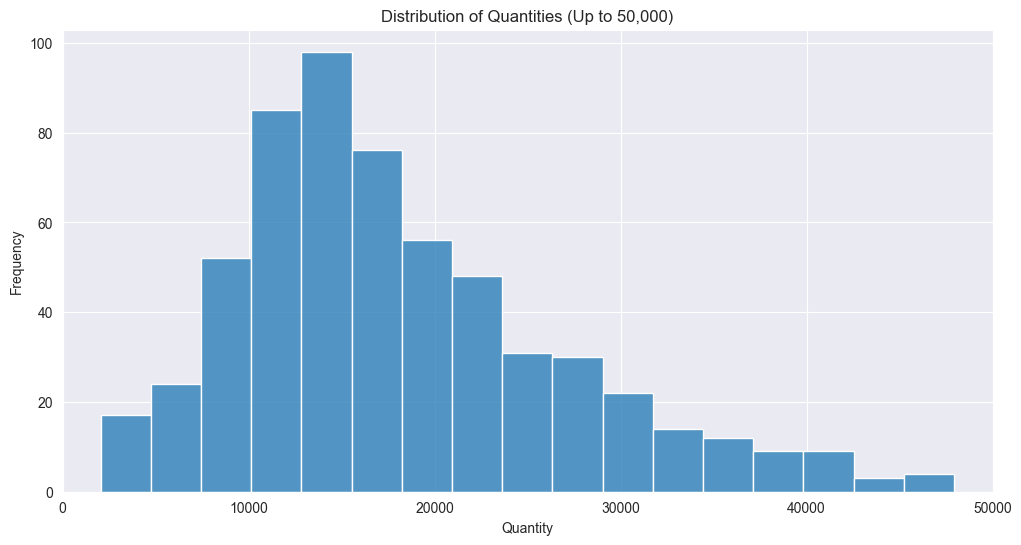

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(df["quantity"])
plt.xlim(0, 50000)
plt.title('Distribution of Quantities (Up to 50,000)')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show();


In [30]:
#Two years is roughy 730 days so we have missing date, find them and impute
df.shape

(604, 3)

In [31]:
def find_date_range(df):
    min_date =df['date'].min()
    max_date = df['date'].max()
    date_range = pd.date_range(start=min_date, end=max_date)
    df = df.set_index('date').reindex(date_range).rename_axis('date').reset_index()
    return  df

In [32]:
daily_sales_volume = find_date_range(df)
daily_sales_volume.shape

(739, 3)

In [33]:
daily_sales_volume.head()

,date,quantity,quantity_winsorized
0,2009-12-01,26434.0,26434.0
1,2009-12-02,31938.0,31938.0
2,2009-12-03,50898.0,50898.0
3,2009-12-04,21405.0,21405.0
4,2009-12-05,5119.0,5119.0


In [35]:
daily_sales_volume.isna().sum()

##There are now 135 dates with null values

date                     0
quantity               135
quantity_winsorized    135
dtype: int64

In [38]:
#Backfill all the null dates to preserve the directon of trend
# Fill any remaining NaN values
daily_sales_volume = daily_sales_volume.fillna(method='bfill')
daily_sales_volume.isna().sum()

date                   0
quantity               0
quantity_winsorized    0
dtype: int64

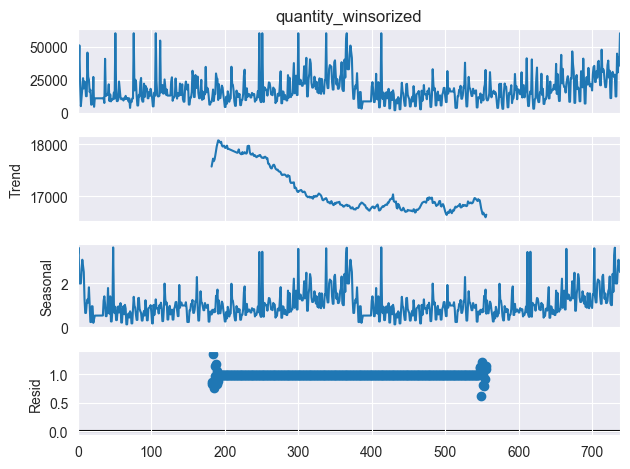

In [40]:
# Decompose the time series
decomposition = seasonal_decompose(daily_sales_volume['quantity_winsorized'], model='multiplicative', period=365)
fig = decomposition.plot()
plt.show();

#downward trend

In [42]:
daily_sales_volume = daily_sales_volume[["date","quantity_winsorized"]]
daily_sales_volume.head(15)

,date,quantity_winsorized
0,2009-12-01,26434.0
1,2009-12-02,31938.0
2,2009-12-03,50898.0
3,2009-12-04,21405.0
4,2009-12-05,5119.0
5,2009-12-06,11623.0
6,2009-12-07,18557.0
7,2009-12-08,26172.0
8,2009-12-09,18403.0
9,2009-12-10,23718.0


In [44]:
daily_sales_volume.rename(columns={"quantity_winsorized":"quantity"},inplace=True)
daily_sales_volume.to_csv("processed.csv")
daily_sales_volume.head()

,date,quantity
0,2009-12-01,26434.0
1,2009-12-02,31938.0
2,2009-12-03,50898.0
3,2009-12-04,21405.0
4,2009-12-05,5119.0
